In [26]:
#!/usr/bin/env python3
# visualize_with_gradcam_lib.py
# 使用 pytorch-grad-cam 库实现 CAM 可视化

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import os
from pathlib import Path
import random
from typing import List, Optional, Union

# 导入 UNetPlusPlus_Classifier 模型
from DL_models.UNetPlusPlus import UNetPlusPlus_Classifier

# 导入 pytorch-grad-cam 库
from pytorch_grad_cam import (
    GradCAM,
    GradCAMPlusPlus,
    ScoreCAM,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
    LayerCAM,
    EigenGradCAM,
)

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
%matplotlib inline

In [27]:
def get_cam_method(method_name: str):
    """
    获取指定的 CAM 方法

    Args:
        method_name: CAM 方法名称

    Returns:
        CAM 方法类
    """
    method_mapping = {
        "gradcam": GradCAM,
        "gradcam++": GradCAMPlusPlus,
        "scorecam": ScoreCAM,
        "ablationcam": AblationCAM,
        "xgradcam": XGradCAM,
        "eigencam": EigenCAM,
        "eigengradcam": EigenGradCAM,
        "layercam": LayerCAM,
        "fullgrad": FullGrad,
    }

    method_name = method_name.lower()
    if method_name not in method_mapping:
        print(f"Warning: Unknown CAM method '{method_name}', defaulting to GradCAM")
        return GradCAM

    return method_mapping[method_name]

In [28]:
def load_model_and_images(
    weights_path: str,
    img_dir: str,
    num_classes: int = 3,
    num_images: int = 4,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    """
    加载模型和随机图片

    Args:
        weights_path: 模型权重路径
        img_dir: 图片目录
        num_classes: 类别数量
        num_images: 需要可视化的图片数量
        device: 设备

    Returns:
        model, images, image_paths
    """
    # 加载模型
    model = UNetPlusPlus_Classifier(n_classes=num_classes, pretrained=None, freeze_encoder=False)
    # 使用 weights_only=True 进行安全加载
    model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True), strict=False)
    model.to(device).eval()

    # 获取图片路径
    img_dir = Path(img_dir)
    all_images = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    image_paths = [img_dir / img_name for img_name in selected_images]

    # 预处理图片
    prep = T.Compose(
        [
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    # 用于显示的图像预处理（不做归一化）
    prep_display = T.Compose(
        [
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
        ]
    )

    processed_images = []
    display_images = []

    for img_path in image_paths:
        img_pil = Image.open(img_path).convert("RGB")

        # 处理用于模型输入的图像
        img_tensor = prep(img_pil).unsqueeze(0).to(device)
        processed_images.append(img_tensor)

        # 处理用于显示的图像
        display_img = prep_display(img_pil)
        display_images.append(display_img)

    return model, processed_images, display_images, image_paths

In [29]:
import cv2


def visualize_with_cam(
    model: torch.nn.Module,
    images: List[torch.Tensor],
    display_images: List[torch.Tensor],
    image_paths: List[Path],
    target_layer,
    class_idx: int = 1,
    cam_method: str = "gradcam",
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    """
    使用 CAM 可视化模型

    Args:
        model: 模型
        images: 预处理后的图像列表
        display_images: 用于显示的图像列表
        image_paths: 图像路径列表
        target_layer: 目标层
        class_idx: 类别索引
        cam_method: CAM 方法名称
        device: 设备
    """
    # 获取 CAM 方法
    cam_algorithm = get_cam_method(cam_method)

    # 创建 CAM 对象 - 移除 use_cuda 参数
    cam = cam_algorithm(model=model, target_layers=[target_layer])

    # 创建图表
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))

    # 单张图片的情况
    if num_images == 1:
        axes = axes.reshape(1, -1)

    for i, (input_tensor, display_img, img_path) in enumerate(zip(images, display_images, image_paths)):
        # 创建目标类别
        targets = [ClassifierOutputTarget(class_idx)]

        # 获取图像概率分布
        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.sigmoid(logits)

        # 生成 CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)

        # 获取第一张图片的热力图（因为batch size=1）
        grayscale_cam = grayscale_cam[0]

        # 将图像转为 numpy 数组用于显示
        rgb_img = display_img.permute(1, 2, 0).numpy()

        # 使用 show_cam_on_image 叠加热力图
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, colormap=cv2.COLORMAP_JET)

        # 显示原图
        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f"Original Image - {img_path.name}", fontsize=12)
        axes[i, 0].axis("off")

        # 显示有 CAM 的图像
        axes[i, 1].imshow(visualization)
        axes[i, 1].set_title(f"{cam_method.upper()} (Class {class_idx})\nProb: {probs[0][class_idx]:.4f}", fontsize=12)
        axes[i, 1].axis("off")

        # 打印预测概率
        print(f"Image {i+1} ({img_path.name}) - Class {class_idx} probability: {probs[0][class_idx]:.4f}")

    plt.tight_layout()
    plt.show()

In [30]:
# 配置参数
CONFIG = {
    "weights_path": "models/UNetPlusPlus_Classifier_20250503_181507.pth",  # 模型权重路径
    "img_dir": "smoke-segmentation.v5i.coco-segmentation/test",  # 图片目录
    "class_idx": 2,  # 目标类别索引
    "method": "gradcam",  # CAM方法
    "layer": "conv4_0",  # 目标层
    "num_images": 4,  # 随机可视化图片数量
    "num_classes": 3,  # 类别数量
}

Using device: cpu
Using gradcam on layer conv4_0 for class 2
Using gradcam on layer conv4_0 for class 2
Image 1 (kooks_1__2024-11-11T08-43-39Z_frame_201_jpg.rf.40438b6e0a3e8928010c7a090522e7f5.jpg) - Class 2 probability: 0.6194
Image 1 (kooks_1__2024-11-11T08-43-39Z_frame_201_jpg.rf.40438b6e0a3e8928010c7a090522e7f5.jpg) - Class 2 probability: 0.6194
Image 2 (kooks_2__2024-09-24T08-11-03Z_frame_2904_jpg.rf.caf275433d010b7e770de513b6f3c7e8.jpg) - Class 2 probability: 0.8135
Image 2 (kooks_2__2024-09-24T08-11-03Z_frame_2904_jpg.rf.caf275433d010b7e770de513b6f3c7e8.jpg) - Class 2 probability: 0.8135
Image 3 (kooks_2__2024-08-19T14-33-50Z_frame_1127_jpg.rf.fcadb98f436e930903cee0c6128a3d08.jpg) - Class 2 probability: 0.7781
Image 3 (kooks_2__2024-08-19T14-33-50Z_frame_1127_jpg.rf.fcadb98f436e930903cee0c6128a3d08.jpg) - Class 2 probability: 0.7781
Image 4 (kooks_2__2024-08-04T06-32-52Z_frame_2361_jpg.rf.8fd66e2e48bea9a1d13eaf0aa56dd9fc.jpg) - Class 2 probability: 0.7434
Image 4 (kooks_2__2024-

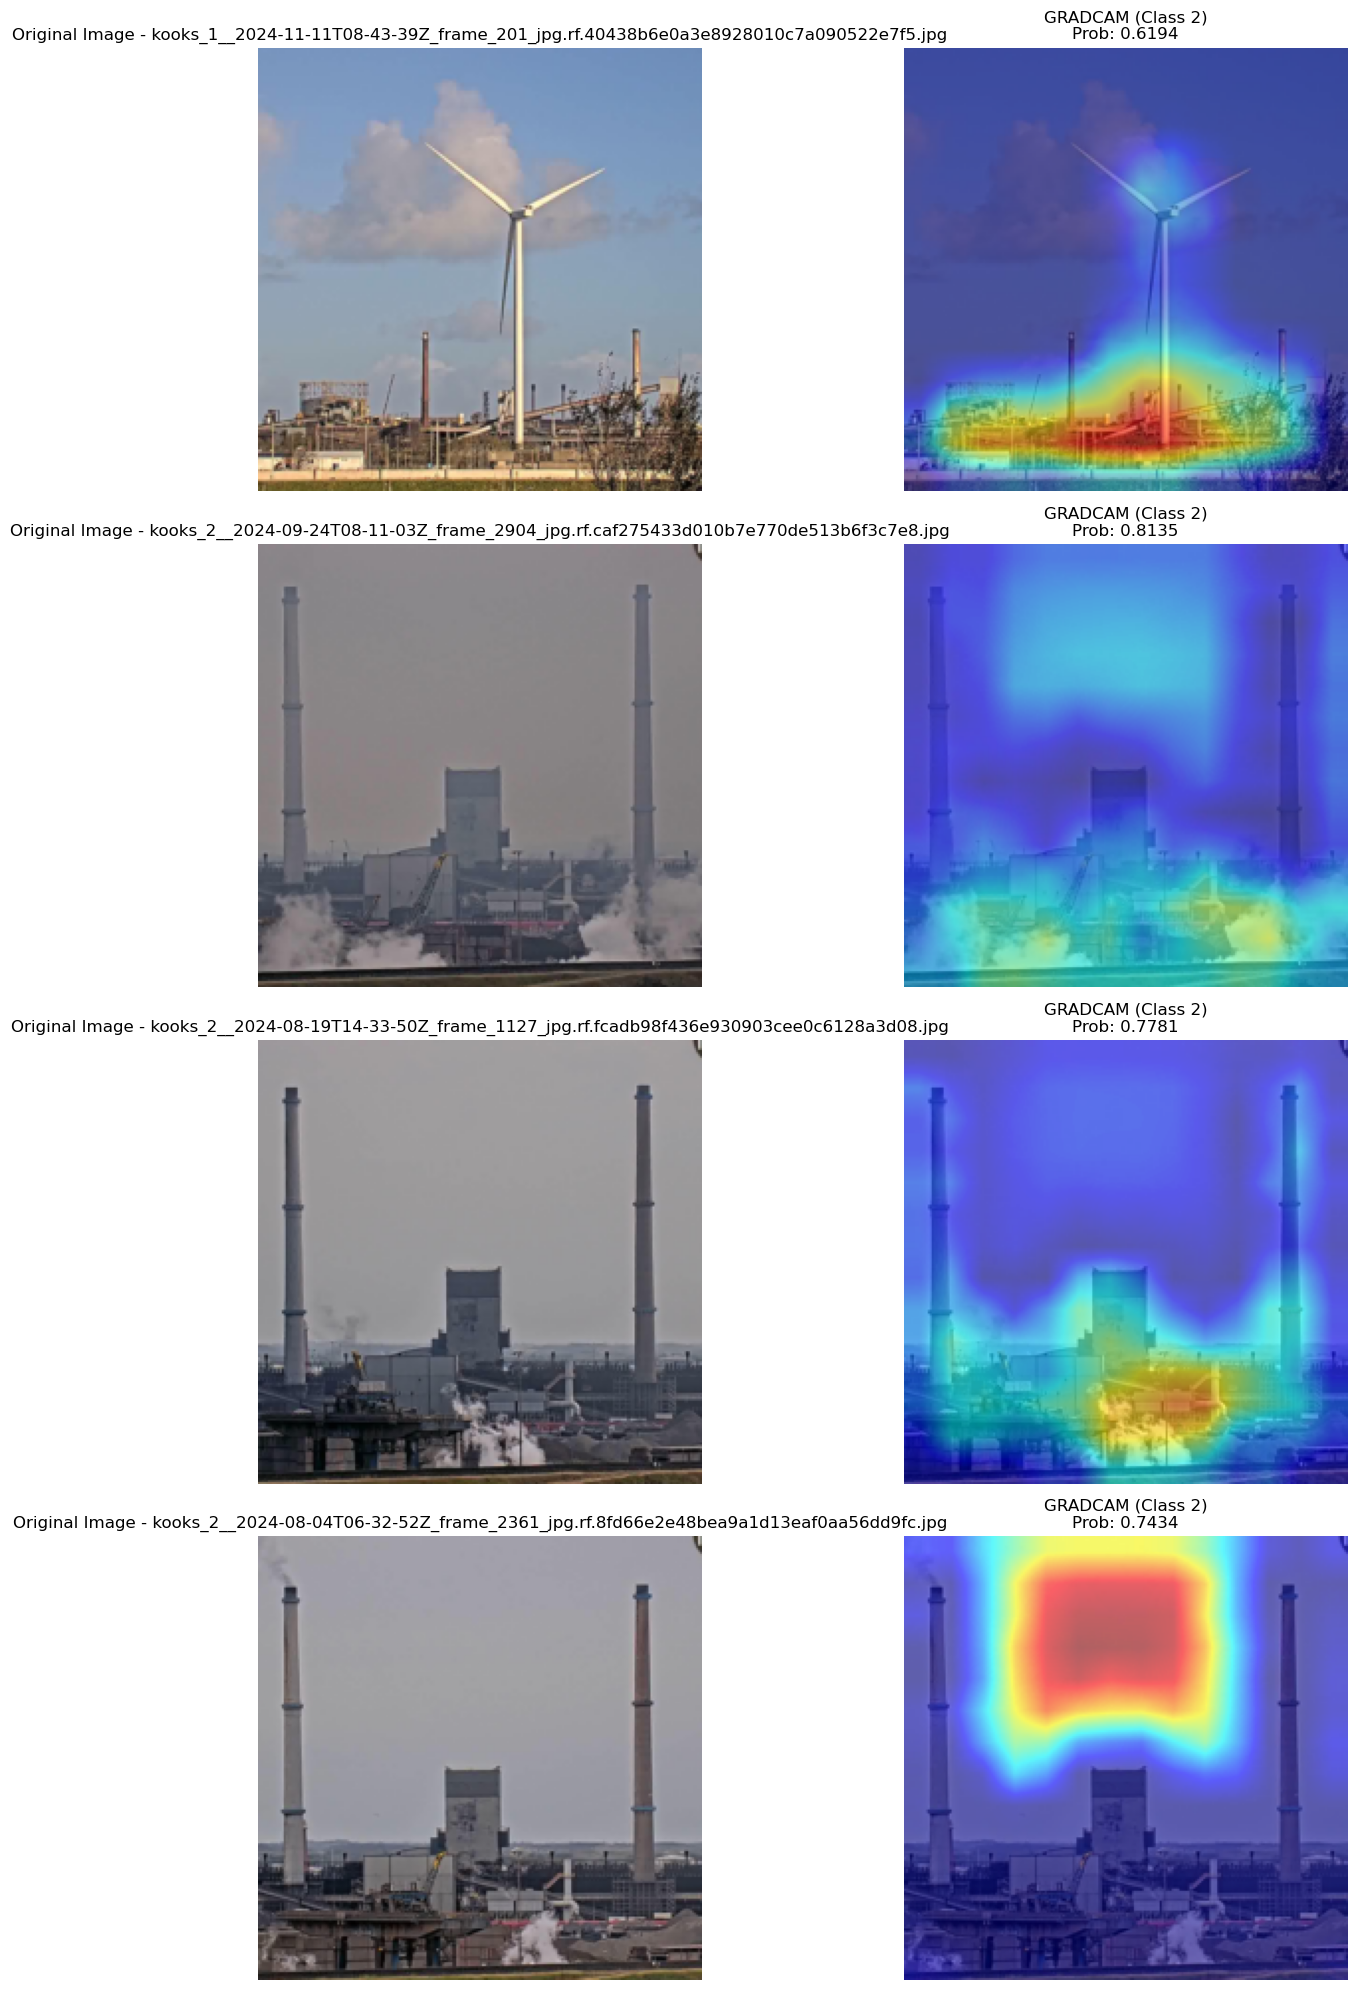

In [31]:
# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 加载模型和图像
model, images, display_images, image_paths = load_model_and_images(
    CONFIG["weights_path"], 
    CONFIG["img_dir"], 
    num_classes=CONFIG["num_classes"],
    num_images=CONFIG["num_images"], 
    device=device
)

# 选择目标层
layer_mapping = {
    "conv4_0": model.encoder.conv4_0,
    "conv3_0": model.encoder.conv3_0,
    "conv2_0": model.encoder.conv2_0,
    "conv1_0": model.encoder.conv1_0,
    "conv0_0": model.encoder.conv0_0,
}

target_layer = layer_mapping.get(CONFIG["layer"])
if target_layer is None:
    raise ValueError(f"Unknown layer: {CONFIG['layer']}")

print(f"Using {CONFIG['method']} on layer {CONFIG['layer']} for class {CONFIG['class_idx']}")

# 可视化
visualize_with_cam(
    model=model,
    images=images,
    display_images=display_images,
    image_paths=image_paths,
    target_layer=target_layer,
    class_idx=CONFIG["class_idx"],
    cam_method=CONFIG["method"],
    device=device,
)